In [1]:
#from IPython.core.display import display, HTML
from IPython.display import display, HTML
display(HTML("<style>.container { width: 98% !important; }</style>"))

In [2]:
import numpy as np
import os
import multiprocessing
num_processes = multiprocessing.cpu_count()  # Adjust this to the desired number of processes
import scipy.stats

In [3]:
def perform_PBC(L, dx_direct):
    L0 = np.sqrt(np.sum(np.power(L[0,:], 2)))
    L1 = np.sqrt(np.sum(np.power(L[1,:], 2)))
    L2 = np.sqrt(np.sum(np.power(L[2,:], 2)))
    L0hat = L[0,:]/L0
    L1hat = L[1,:]/L1
    L2hat = L[2,:]/L2
    #dx_cartesian  = dx_direct @ L # Conversion from direct to cartesian
    dx_cartesian  = dx_direct
    Natoms = dx_cartesian.shape[0]
    for i in range(Natoms):
        # correct along the 1st vector
        d0 = np.dot(dx_cartesian[i, :], L0hat)
        if (d0 >= L0/2):
            dx_cartesian[i,:] -= L[0,:]
        elif (d0 < -L0/2):
            dx_cartesian[i,:] += L[0,:]
        # correct along the 2nd vector
        d1 = np.dot(dx_cartesian[i,:],L1hat)
        if (d1 >= L1/2):
            dx_cartesian[i,:] -= L[1,:]
        elif (d1 < -L1/2):
            dx_cartesian[i,:] += L[1,:]
        # correct along the 3rd vector
        d2 = np.dot(dx_cartesian[i,:],L2hat)
        if (d2 >= L2/2):
            dx_cartesian[i,:] -= L[2,:]
        elif (d2 < -L2/2):
            dx_cartesian[i,:] += L[2,:]
        
    return dx_cartesian

In [4]:
def get_equil_info_for_specific_element(poscar_equil_path, desired_element):
    filename = poscar_equil_path
    L = np.zeros((3, 3))
    with open(filename, "r") as f:
        lines = f.readlines()
    
    # Read the cell vectors
    counter = 0
    for i in range(2,5,1):
        templ = lines[i].split() 
        L[counter, :] = [float(templ[0]), float(templ[1]), float(templ[2])]
        counter += 1
    templ = lines[6].split() # for Nspecies
    Number_of_species = len(templ)
    Nspecies = np.zeros(Number_of_species, dtype=int)   

    for i in range(Number_of_species):
        Nspecies[i] = int(templ[i])
    
    templ = lines[5].split() # for elements included 
    countelement = 0
    for i in range(Number_of_species):
        if templ[i] == desired_element:
            desired_element_sequence = countelement
            break
        countelement += 1
    
    Ndesiredelement = Nspecies[desired_element_sequence]
    x0 = np.zeros((Ndesiredelement, 3))
    N1 = 0
    for i in range(desired_element_sequence):
        N1 += Nspecies[i]
    N1 += 8
    #N2 = np.sum(Nspecies[0:-1])
    counter = 0
    #for i in range(N1+N2, N1+N2+Noxygen):
    for i in range(N1, N1+Ndesiredelement):
        templ = lines[i].split()
        x0[counter, :] = [float(templ[0]), float(templ[1]), float(templ[2])]
        counter += 1
    return x0, L

In [5]:
def get_coords_vs_time(xyz_path, Ndesiredelement):
    filename = xyz_path
    with open(filename, "r") as f:
        lines = f.readlines()
    
    #templ = lines[6].split() # for Nspecies
    #Number_of_species = len(templ)
    #Nspecies = np.zeros(Number_of_species, dtype=int)
    #for i in range(Number_of_species):
    #    Nspecies[i] = int(templ[i])

    #templ = lines[5].split() # for elements included 
    #countelement = 0
    #for i in range(Number_of_species):
    #    if templ[i] == desired_element:
    #        desired_element_sequence = countelement
    #        break
    #    countelement += 1
    
    #Ndesiredelement = Nspecies[desired_element_sequence]
    
    #N1 = 7
    N2 = 2 # Rejecting reading the first and second lines in each block in the xyz file
    Nheaders = 0 # No header in the file that does not repeat in the xyz file
    Nsnapshots = int((len(lines)-Nheaders)/(Ndesiredelement+N2))
    #Nsnapshots = 100 ################################################################### CHANGE THIS LATER
    x_total = np.zeros((Nsnapshots*Ndesiredelement, 3))
    counter = 0
    for i in range(Nsnapshots):
        N1 = Nheaders + i*(Ndesiredelement+N2)
        for j in range(N1+N2, N1+N2+Ndesiredelement):
            #print(j)
            #print(lines[j])
            templ = lines[j].split()
            
            x_total[counter, :] = [float(templ[1]), float(templ[2]), float(templ[3])] # Let's not read the atomtype
            counter += 1

    return x_total, Nsnapshots

In [6]:
def get_x_info(xdatcar_path, desired_element):
    filename = xdatcar_path
    with open(filename, "r") as f:
        lines = f.readlines()
    
    templ = lines[6].split() # for Nspecies
    Number_of_species = len(templ)
    Nspecies = np.zeros(Number_of_species, dtype=int)
    for i in range(Number_of_species):
        Nspecies[i] = int(templ[i])

    templ = lines[5].split() # for elements included 
    countelement = 0
    for i in range(Number_of_species):
        if templ[i] == desired_element:
            desired_element_sequence = countelement
            break
        countelement += 1
    
    Ndesiredelement = Nspecies[desired_element_sequence]
    
    #N1 = 7
    N2 = np.sum(Nspecies[0:desired_element_sequence]) + 1 # Rejecting reading other species and the "Direct configuration" line
    Nheaders = 7
    Natoms = np.sum(Nspecies)
    Nsnapshots = int((len(lines)-Nheaders)/(Natoms+1))
    x_total = np.zeros((Nsnapshots*Ndesiredelement, 3))
    counter = 0
    for i in range(Nsnapshots):
        N1 = Nheaders + i*(Natoms+1)
        for i in range(N1+N2, N1+N2+Ndesiredelement):
            templ = lines[i].split()
            x_total[counter, :] = [float(templ[0]), float(templ[1]), float(templ[2])]
            counter += 1

    return x_total, Ndesiredelement

In [7]:
# Read coordinates -- equilibirum -- i.e., sites

NLi = 4
NLa = 4
NTi = 8
NOx = 24

# Input filenames
poscar_equil_path = "./POSCAR"
#xdatcar_path = "./total_XDATCAR_800"
element_for_equil = 'Li'

# read equilibirum POSCAR file
x_sites_direct, L = get_equil_info_for_specific_element(poscar_equil_path, element_for_equil) # x0 is the equilibrium position of oxygen atoms
Nsites = x_sites_direct.shape[0]

xO_equil, L = get_equil_info_for_specific_element(poscar_equil_path, 'O') # Let's get equilibrium O positions too!

# read the generated XDATCAR file
#convert_traj_to_xdatcar(traj_filename)
#x_total, Nox = get_x_info(xdatcar_path, element)

In [8]:
######## Related to XDATCAR generation from xyz file

# Read coordinates -- vs. time

xyz_path_La = f"./file_La.xyz"
xyz_path_Li = f"./file_Li.xyz"
xyz_path_Ti = f"./file_Ti.xyz"
xyz_path_O = f"./file_O.xyz"

coords_La, Nsnapshots = get_coords_vs_time(xyz_path_La, NLa)
coords_Li, Nsnapshots = get_coords_vs_time(xyz_path_Li, NLi)
coords_Ti, Nsnapshots = get_coords_vs_time(xyz_path_Ti, NTi)
coords_O, Nsnapshots = get_coords_vs_time(xyz_path_O, NOx)


In [9]:
######## Related to XDATCAR generation from xyz file

coords_La_direct = coords_La @ np.linalg.inv(L)
coords_Li_direct = coords_Li @ np.linalg.inv(L)
coords_Ti_direct = coords_Ti @ np.linalg.inv(L)
coords_O_direct = coords_O @ np.linalg.inv(L)

precision = 6  # Set the desired precision

filename_xdatcar = f"./XDATCAR_generated"
#print(filename_out)
with open(filename_xdatcar, 'w') as file:
    file.write("LAMMPS to XDATCAR\n")
    file.write("1.0\n")
    file.write("    {:.{}f}    {:.{}f}    {:.{}f}\n".format(L[0][0], precision, L[0][1], precision, L[0][2], precision))
    file.write("    {:.{}f}    {:.{}f}    {:.{}f}\n".format(L[1][0], precision, L[1][1], precision, L[1][2], precision))
    file.write("    {:.{}f}    {:.{}f}    {:.{}f}\n".format(L[2][0], precision, L[2][1], precision, L[2][2], precision))
    file.write("    {}    {}    {}    {}\n".format('La', 'Li', 'Ti', 'O'))
    file.write("    {}    {}    {}    {}\n".format(NLa, NLi, NTi, NOx))
    for nframe in range(Nsnapshots):
    #for nframe in range(int(Nsnapshots/10000)):
        file.write("Direct configuration=     {}\n".format(nframe))
        for i in range(NLa):
            file.write("    {:.{}f}    {:.{}f}    {:.{}f}\n".format(coords_La_direct[nframe*NLa + i][0], precision, coords_La_direct[nframe*NLa + i][1], precision, coords_La_direct[nframe*NLa + i][2], precision))
        for i in range(NLi):
            file.write("    {:.{}f}    {:.{}f}    {:.{}f}\n".format(coords_Li_direct[nframe*NLi + i][0], precision, coords_Li_direct[nframe*NLi + i][1], precision, coords_Li_direct[nframe*NLi + i][2], precision))
        for i in range(NTi):
            file.write("    {:.{}f}    {:.{}f}    {:.{}f}\n".format(coords_Ti_direct[nframe*NTi + i][0], precision, coords_Ti_direct[nframe*NTi + i][1], precision, coords_Ti_direct[nframe*NTi + i][2], precision))
        for i in range(NOx):
            file.write("    {:.{}f}    {:.{}f}    {:.{}f}\n".format(coords_O_direct[nframe*NOx + i][0], precision, coords_O_direct[nframe*NOx + i][1], precision, coords_O_direct[nframe*NOx + i][2], precision))

In [10]:
### Input params

#poscar_equil_path = "./POSCAR_all_Li_for_equil"
xdatcar_path = "./XDATCAR_generated"
element = 'Li'
dt = 1 # fs # timestep between coordinate outputs in MD


In [11]:
# read equilibirum POSCAR file
#x_sites, L = get_equil_info_for_specific_element(poscar_equil_path, element) # x0 is the equilibrium position of oxygen atoms
#Nsites = x_sites.shape[0]

# read the XDATCAR file
x_total, NLi = get_x_info(xdatcar_path, element)

In [12]:
# Wish downselecting (?)
# x will be the array you need to use for further calculations
Neverythis = 1
Nsnapshots = int(x_total.shape[0]/NLi)
downselected_snapshots = np.arange(0, Nsnapshots, Neverythis)
Nsnaps = len(downselected_snapshots)
print("Number of snapshots that will be used is: %d" %Nsnaps)
x = np.zeros((len(downselected_snapshots)*NLi, 3))
counter = 0
for i in downselected_snapshots:
    idx1total = i*NLi
    idx2total = (i+1)*NLi
    idx1 = counter*NLi
    idx2 = (counter+1)*NLi
    x[idx1:idx2, :] = x_total[idx1total:idx2total, :]
    counter += 1

Number of snapshots that will be used is: 2000001


In [13]:
Num_4O_BNs_all = 24
indx_4O_BNs_all = np.empty([Num_4O_BNs_all, 4], dtype=int)

indx_4O_BNs_all [0, :] = [19, 2, 5, 18]
indx_4O_BNs_all [1, :] = [14, 13, 3, 2]
indx_4O_BNs_all [2, :] = [12, 9, 8, 13]
indx_4O_BNs_all [3, :] = [21, 18, 7, 9]
indx_4O_BNs_all [4, :] = [7, 5, 3, 8]
indx_4O_BNs_all [5, :] = [14, 19, 21, 12]
indx_4O_BNs_all [6, :] = [16, 6, 12, 19]# Lx
indx_4O_BNs_all [7, :] = [10, 1, 8, 5]#
indx_4O_BNs_all [8, :] = [1, 6, 13, 2]#
indx_4O_BNs_all [9, :] = [10, 16, 9, 18]#
indx_4O_BNs_all [10, :] = [23, 4, 14, 21]# Ly
indx_4O_BNs_all [11, :] = [11, 15, 3, 7]#
indx_4O_BNs_all [12, :] = [23, 11, 2, 18]#
indx_4O_BNs_all [13, :] = [4, 15, 13, 9]#
indx_4O_BNs_all [14, :] = [17, 24, 12, 8]# Lz
indx_4O_BNs_all [15, :] = [22, 20, 19, 5]#
indx_4O_BNs_all [16, :] = [20, 24, 21, 7]#
indx_4O_BNs_all [17, :] = [22, 17, 14, 3]#
indx_4O_BNs_all [18, :] = [4, 6, 16, 23]# LxLy
indx_4O_BNs_all [19, :] = [15, 1, 10, 11]# 
indx_4O_BNs_all [20, :] = [22, 1, 6, 17]# LxLz
indx_4O_BNs_all [21, :] = [20, 10, 16, 24]#
indx_4O_BNs_all [22, :] = [24, 4, 15, 17]# LyLz
indx_4O_BNs_all [23, :] = [20, 23, 11, 22]#

indx_4O_BNs_all -= 1

In [14]:
# We need to calculate which site is connected to which site and through which BN
# Let's just use POSCAR_equil for this purpose -- you need to grab the O coordinates as well.

#BNO4_indx_matrix = np.zeros((Nsites, Nsites, 4), dtype=int)
BNO4_ids_matrix = np.zeros((Nsites, Nsites, 2), dtype=int) # Storing the two BN #s in between i and j sites.
NN12_O_to_site = np.zeros((Nsites, 12), dtype=int)

x_sites  = x_sites_direct @ L # Conversion from direct to cartesian

# First, let's determine the 12 NN O atoms to each site
for i in range(Nsites):
    dist_with_O_atoms = np.zeros(NOx)
    dx_O_atoms = np.zeros((NOx, 3))
    for j in range(NOx):
        dx_O_atoms[j] = x_sites[i] - coords_O[j]  # You need the O coordinates!!!! Use the first napshot from XDATCAR
    dx_O_atoms_PBC_corrected = perform_PBC(L, dx_O_atoms)
    for j in range(NOx):
        dist_with_O_atoms[j] = np.sqrt(np.sum(np.power(dx_O_atoms_PBC_corrected[j], 2)))
    
    sorted_dists_ids = np.argsort(dist_with_O_atoms)
    NN12_O_to_site[i] = sorted_dists_ids[0: 12]
    #sorted_dists = np.sort(dist_with_O_atoms)
    #print(NN12_O_to_site[0: 12])

Num_4O_BNs = 0
# Then whichever sites have 4 O ids that are the same: they are adjacent sites and the O ids are the 4O BN ids!
for i in range(Nsites):
    for j in range(Nsites):
        if i != j:
            # Find the common elements between the two arrays
            common_elements = np.intersect1d(NN12_O_to_site[i], NN12_O_to_site[j])
            #print(len(common_elements))
            if len(common_elements) == 8:
                third_elem = 0 # third indx in the BNO4_ids_matrix array
                for nbn in range(Num_4O_BNs_all):
                    light = 0
                    for nbn_idx in range(4):
                        if np.isin(indx_4O_BNs_all[nbn, nbn_idx], common_elements):
                            light += 1
                    #print(indx_4O_BNs_all[nbn, :], common_elements, light)
                    if light  == 4:
                        #print('k', nbn)
                        BNO4_ids_matrix[i, j, third_elem] = nbn
                        Num_4O_BNs += 1
                        third_elem += 1
                    if third_elem == 2:
                        break
            elif len(common_elements) > 8:
                print(i, j, len(common_elements))
                #print("Oh Sh*t!!!!!")

In [15]:
# Let's simplify the meaningful BNs!! according to the pathways!
BN_pathway_desired = np.empty((0, 3), dtype=int)
for i in range(Nsites):
    for j in range(Nsites):
        if j > i:
            if (BNO4_ids_matrix[i, j] != 0).any():
                print(i+1, j+1, BNO4_ids_matrix[i, j])
                BN_pathway_desired = np.vstack([BN_pathway_desired, [i, j, BNO4_ids_matrix[i, j, 0]]])
                BN_pathway_desired = np.vstack([BN_pathway_desired, [i, j, BNO4_ids_matrix[i, j, 1]]])
print(BN_pathway_desired)
print(BN_pathway_desired.shape)

1 3 [1 3]
2 3 [0 2]
3 4 [4 5]
[[0 2 1]
 [0 2 3]
 [1 2 0]
 [1 2 2]
 [2 3 4]
 [2 3 5]]
(6, 3)


In [16]:
######## Related to site info

def split_into_chunks(m_range, num_processes):
    chunk_size, remainder = divmod(len(m_range), num_processes)
    m_range = list(m_range)  # Convert the range to a list
    chunks = [m_range[i * chunk_size + min(i, remainder):(i + 1) * chunk_size + min(i + 1, remainder)] for i in range(num_processes)]    
    return chunks

def distance_all_call(chunk, Nsites, NLi, x_sites, x, L):
    dx = np.zeros((Nsites, 3))
    dx_cartesian = np.zeros((Nsites, 3))
    dist = np.zeros(Nsites)
    chunk = list(chunk)
    Nsnapshots3 = len(chunk)
    
    distance_all_snaps_temp = np.zeros((Nsnapshots3 * NLi, Nsites))

    x_chunk = x[chunk[0]*NLi:(chunk[-1]+1)*NLi:, :]
    for n in range(Nsnapshots3):
        for i in range(NLi):
            for j in range(Nsites):
                dx[j, :] = x_chunk[n*NLi+i, :] - x_sites[j, :]
            dx  = dx @ L # Conversion from direct to cartesian
            dx_cartesian = perform_PBC(L, dx) # this includes PBC correction, too.
            for j in range(Nsites):
                dist[j] = np.sqrt(np.sum(np.power(dx_cartesian[j, :], 2)))
            distance_all_snaps_temp[n*NLi + i, :] = dist

    return distance_all_snaps_temp

def one_over_distance2_all_call(chunk, NLi, distance_all_snaps): ############# Correction needed: Nsites is used in the function but has not been passed to it!
    #dx = np.zeros((Nsites, 3))
    #dx_cartesian = np.zeros((Nsites, 3))
    #dist = np.zeros(Nsites)
    chunk = list(chunk)
    Nsnapshots3 = len(chunk)
    
    one_over_distance2_all_snaps_temp = np.zeros((Nsnapshots3 * NLi, Nsites))

    distance_all_snaps_chunk = distance_all_snaps[chunk[0]*NLi:(chunk[-1]+1)*NLi:, :]
    for n in range(Nsnapshots3):
        for i in range(NLi):
            zero_indices = np.where(distance_all_snaps_chunk[n*NLi + i, :] == 0)
            if zero_indices[0].size > 0:
                one_over_distance2_all_snaps[n*NLi + i, zero_indices[0]] = 1
            else:
                usethissum = np.sum(np.power(distance_all_snaps_chunk[n*NLi + i, :], -2))
                for j in range(Nsites):
                    one_over_distance2_all_snaps_temp[n*NLi + i, j] = 1./np.square(distance_all_snaps_chunk[n*NLi + i, j]) / usethissum

    return one_over_distance2_all_snaps_temp

# Calculating all the distances to all the sites
distance_all_snaps = np.zeros((Nsnaps * NLi, Nsites))
m_range = range(Nsnaps)
chunks = split_into_chunks(m_range, num_processes)

with multiprocessing.Pool(num_processes) as pool:
    results = pool.starmap(distance_all_call, [(chunk, Nsites, NLi, x_sites_direct, x, L) for chunk in chunks])

distance_all_snaps = np.concatenate(results, axis=0)

# Making the normalized 1/d^2 distance array
one_over_distance2_all_snaps = np.zeros((Nsnaps * NLi, Nsites))
m_range = range(Nsnaps)
chunks = split_into_chunks(m_range, num_processes)

with multiprocessing.Pool(num_processes) as pool:
    results = pool.starmap(one_over_distance2_all_call, [(chunk, NLi, distance_all_snaps) for chunk in chunks])

one_over_distance2_all_snaps = np.concatenate(results, axis=0)

# Making the normalized 1/d^2 distance array
topWhat = 3
normalized_top_what_largest = np.zeros((Nsnaps * NLi, topWhat))
indices_top_what_largest = np.zeros((Nsnaps * NLi, topWhat), dtype=int)

for n in range(Nsnaps):
    if n%5000 == 0:
        print(n)
    for i in range(NLi):
        arr = one_over_distance2_all_snaps[n*NLi + i, :]
        arr_sorted = np.sort(arr)
        top_what_largest = arr_sorted[-topWhat:]
        indices_top_what_largest[n*NLi + i, :] = np.argsort(arr)[-topWhat:]
        normalized_top_what_largest[n*NLi + i, :] = top_what_largest / np.sum(top_what_largest)

# Write the position of hopping atoms into file
x_cartesian = x @ L # Conversion from direct to cartesian # If we are reading XDATCAR with direct coordinates, the conversion should happen!
#x_cartesian = x
filename = "./r_hopping_atom_cartesian" + ".txt"
f_hopping_atom_r = open(filename, "w")
for nt in range(Nsnaps):
    for i in range(NLi):
        f_hopping_atom_r.write("%d %f %f %f\n" %(2, x_cartesian[nt*NLi + i, 0], x_cartesian[nt*NLi + i, 1], x_cartesian[nt*NLi + i, 2]))
f_hopping_atom_r.close()

# Write the topwhat largest numbers into file (value in one file and index in another)
# values
filename = "./site_info_continuous_spectrum_topwhat_values" + ".txt"
f_hopping_atom_v = open(filename, "w")
for n in range(Nsnaps):
    for i in range(NLi):    
        for j in range(topWhat):
            f_hopping_atom_v.write("%f " %(normalized_top_what_largest[n*NLi + i, j]))
        f_hopping_atom_v.write("\n")
f_hopping_atom_v.close()

# indices
filename = "./site_info_continuous_spectrum_topwhat_indices" + ".txt"
f_hopping_atom_i = open(filename, "w")
for n in range(Nsnaps):
    for i in range(NLi):    
        for j in range(topWhat):
            f_hopping_atom_i.write("%d " %(indices_top_what_largest[n*NLi + i, j]))
        f_hopping_atom_i.write("\n")
f_hopping_atom_i.close()

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000
270000
275000
280000
285000
290000
295000
300000
305000
310000
315000
320000
325000
330000
335000
340000
345000
350000
355000
360000
365000
370000
375000
380000
385000
390000
395000
400000
405000
410000
415000
420000
425000
430000
435000
440000
445000
450000
455000
460000
465000
470000
475000
480000
485000
490000
495000
500000
505000
510000
515000
520000
525000
530000
535000
540000
545000
550000
555000
560000
565000
570000
575000
580000
585000
590000
595000
600000
605000
610000
615000
620000
625000
630000
635000
640000
645000
650000
655000
660000
665000
670000
675000
680000
685000
690000
695000
700000
705000
710000
715000
720000
725000
730

(8000004, 3)


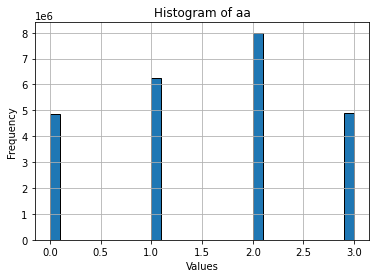

In [17]:
aa = np.loadtxt('site_info_continuous_spectrum_topwhat_indices.txt')
print(aa.shape)

import numpy as np
import matplotlib.pyplot as plt

# Assuming aa is your NumPy array
# For demonstration, let's create a sample array
#aa = np.random.randn(1000)  # Generating 1000 random values

# Creating a histogram
plt.hist(aa.flatten(), bins=30, edgecolor='black')  # Adjust the number of bins as needed
#plt.hist(aa, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of aa')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [18]:
## FFT Corr calculation function

def cross_correlation_fft_zero_padding_normalized(var1, var2):
    # Make sure both variables are of the same length
    if len(var1) != len(var2):
        raise ValueError("Input variables must have the same length")

    # Calculate the FFT of the variables with zero-padding
    fft_size = 2 * len(var1)
    fft_var1 = np.fft.fft(var1, fft_size)
    fft_var2 = np.fft.fft(var2, fft_size)

    # Calculate the complex conjugate of the second variable
    conj_fft_var2 = np.conj(fft_var2)

    # Calculate the cross-correlation in the frequency domain
    cross_corr_freq = fft_var1 * conj_fft_var2

    # Perform inverse FFT to get back to the time domain
    cross_corr_time = np.fft.ifft(cross_corr_freq)

    # Normalize the result
    #cross_corr_time /= fft_size  # Normalization #1 (FFTW) -- not needed for this fft from numpy actually 
    cross_corr_time /= np.concatenate([np.arange(len(var1), 0, -1), np.arange(1, len(var1) + 1)]) # Normalization #2 (Allen-Tidesly)
    
    return cross_corr_time.real


In [19]:
# Get the atomic velocities

#dt = 1 # fs # timestep between coordinate outputs # After the downselection

vel = np.zeros(((Nsnaps-1) * NLi, 3))
dx = np.zeros(((Nsnaps-1) * NLi, 3))

for ns in range(Nsnaps-1):
    for i in range(NLi):
        dx[ns * NLi + i, :] = x[ns * NLi + i, :] - x[(ns+1) * NLi + i, :]
        
dx  = dx @ L # Conversion from direct to cartesian
dx_cartesian = perform_PBC(L, dx)
vel = dx_cartesian / dt

(2000000,)
(2000000,)
D (cm^2/s): 1.5822625752098771e-06


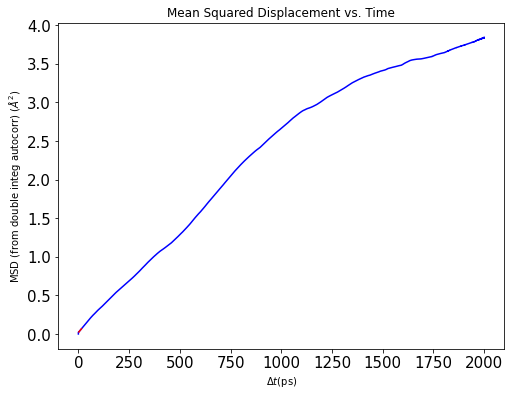

In [20]:
# Diffusion analysis before projection on different local environments
# Correlation for all atoms and all xyz direcitons

cross_corr_final = np.zeros((vel[0::NLi, :].shape[0]))

for nLi in range(NLi):
    for alpha in range(3):
        vel_under_consideration = vel[nLi::NLi, alpha]
        #vel_under_consideration = vel[nLi::NLi, alpha] - np.mean(vel[nLi::NLi, alpha])
        # Calculate cross-correlation using FFT with zero-padding

        var1 = vel_under_consideration
        var2 = vel_under_consideration

        cross_corr_result = cross_correlation_fft_zero_padding_normalized(var1, var2)
        #print(cross_corr_result.shape)
        #print(len(vel_under_consideration))
        cross_corr_final += cross_corr_result[0: len(vel_under_consideration)]
        
cross_corr_final /= (NLi * 3 * 10) # 10 is for conversion from A^2/fs to cm^2/s
print(cross_corr_final.shape)

import numpy as np
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt

# Generate x-axis values (time * 0.001)
x_values = np.arange(len(cross_corr_final)) * dt # Let's keep the values on the x-axis as fs

# Calculate the cumulative integral using cumtrapz
cumulative_integral_values = cumtrapz(cross_corr_final, x=x_values, initial=0)
cumulative_integral_values_2 = cumtrapz(cumulative_integral_values, x=x_values, initial=0)

print(cumulative_integral_values_2.shape)

begin_data = 100
end_data = 20000

# Plot double integ autocorr
plt.figure(figsize=(8, 6), facecolor='w')
#plt.plot(x / 1000, y, 'b', linewidth=1.5)

plt.plot(x_values / 1000, cumulative_integral_values_2, color='b')

x_for_plot = x_values
y_for_plot = cumulative_integral_values_2

# Perform linear fit
y_for_fit = y_for_plot[begin_data:end_data]
x_for_fit = x_for_plot[begin_data:end_data]
p = np.polyfit(x_for_fit, y_for_fit, 1)

# Plot the linear fit
plt.plot(x_for_fit / 1000, np.polyval(p, x_for_fit), 'r--', linewidth=1.5)

# Set plot properties
plt.xlabel('$\Delta t$(ps)')
plt.ylabel('MSD (from double integ autocorr) ($\\AA^2$)')
plt.title('Mean Squared Displacement vs. Time')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.axis('square')
#plt.show()
plt.savefig('Figure_MSD_before_projection.png')

# Display the slope in cm^2/s
D_in_cm2_per_s = p[0] * 0.5 # the 0.5 coeff is for double integral with double counting! (slide 13 in the pdf by Zabaras) # NO need for 0.1 is to convert from A^2/fs to cm^2/s (applied previously) 
print("D (cm^2/s):", D_in_cm2_per_s)


In [21]:
# Project vel on different local environments

Env_cont_val = np.loadtxt('./site_info_continuous_spectrum_topwhat_values.txt')
Env_cont_indx = np.loadtxt('./site_info_continuous_spectrum_topwhat_indices.txt', dtype=int)

vel_env_prjctd = np.zeros((Nsites, Nsites, 2, NLi, 3, Nsnaps-1))

#sum_for_normalization = 0

for nLi in range(NLi): # Loop over Li atoms
    #print(nLi)
    for alpha in range(3): # Loop over x, y, and z
        vel_under_consideration = vel[nLi::NLi, alpha]
        Nsnaps_vel = vel_under_consideration.shape[0] # This should be Nsnaps-1
        #if Nsnaps_vel != Nsnaps-1:
        #    print('Sh*t')
        for nt in range(Nsnaps_vel):
            sum_for_normalization = 0
            indx1 = nt * NLi + nLi
            indx2 = (nt+1) * NLi + nLi 
            for envi in range(topWhat):
                for envj in range(topWhat):
                    idx_i_env = Env_cont_indx[indx1][envi]
                    idx_j_env = Env_cont_indx[indx2][envj]
                    # BN_pathway_desired
                    #if idx_i_env != idx_j_env:
                    result1 = np.any((BN_pathway_desired[:, 0:2] == idx_i_env), axis=1)
                    result2 = np.any((BN_pathway_desired[:, 0:2] == idx_j_env), axis=1)
                    result3 = result1 & result2
                    if idx_i_env != idx_j_env and result3.any():
                        #if idx_i_env > 2 or idx_j_env > 2:
                        #    print(idx_i_env, idx_j_env)
                        sum_for_normalization += Env_cont_val[indx1][envi] * Env_cont_val[indx2][envj]
        
            for envi in range(topWhat):
                for envj in range(topWhat):
                    idx_i_env = Env_cont_indx[indx1][envi]
                    idx_j_env = Env_cont_indx[indx2][envj]
                    result1 = np.any((BN_pathway_desired[:, 0:2] == idx_i_env), axis=1)
                    result2 = np.any((BN_pathway_desired[:, 0:2] == idx_j_env), axis=1)
                    result3 = result1 & result2
                    if idx_i_env != idx_j_env and result3.any():
                        # the two BNs in b/w these sites are here:
                        BN0 = BNO4_ids_matrix[idx_i_env, idx_j_env, 0]
                        BN1 = BNO4_ids_matrix[idx_i_env, idx_j_env, 1]
                        ids_O_0 = indx_4O_BNs_all[BN0]
                        ids_O_1 = indx_4O_BNs_all[BN1]
                        if (len(ids_O_0) != 4 or len(ids_O_1) != 4):
                            print('Sh*t')
                        # BN0
                        dist0_array = np.zeros((len(ids_O_0), 3))
                        for indxO in range(len(ids_O_0)):
                            dist0_array[indxO, :] = x[NLi*nt + nLi, :] - xO_equil[ids_O_0[indxO], :]
                        dist0_array  = dist0_array @ L # Conversion from direct to cartesian
                        dist0_array_PBC_corrected = perform_PBC(L, dist0_array)
                        dist0 = 0
                        for indxO in range(len(ids_O_0)):
                            dist0 += np.sqrt(np.sum(np.power(dist0_array_PBC_corrected[indxO, :], 2)))
                        # BN1
                        dist1_array = np.zeros((len(ids_O_1), 3))
                        for indxO in range(len(ids_O_1)):
                            dist1_array[indxO, :] = x[NLi*nt + nLi, :] - xO_equil[ids_O_1[indxO], :]
                        dist1_array  = dist1_array @ L # Conversion from direct to cartesian
                        dist1_array_PBC_corrected = perform_PBC(L, dist1_array)
                        dist1 = 0
                        for indxO in range(len(ids_O_1)):
                            dist1 += np.sqrt(np.sum(np.power(dist1_array_PBC_corrected[indxO, :], 2)))    
                        # Let's comapre dist0 and dist0: whichever we are closer to, we take it as the BN nearby...
                        if dist1 > dist0:
                            BN_chosen = 0
                        else:
                            BN_chosen = 1
                        #if idx_i_env != idx_j_env and sum_for_normalization != 0:
                        vel_env_prjctd[idx_i_env][idx_j_env][BN_chosen][nLi][alpha][nt] += vel_under_consideration[nt] * (Env_cont_val[indx1][envi] * Env_cont_val[indx2][envj]) / sum_for_normalization
                    #else:    ## Think about this -- probably not needed (?) as sum_for_normalization will always have a non-zero value?!!!
                    #    vel_env_prjctd[idx_i_env][idx_j_env][nLi][alpha][nt] += vel_under_consideration[nt] * (Env_cont_val[indx1][envi] * Env_cont_val[indx2][envj]) / sum_for_normalization


In [22]:
print(vel_env_prjctd.shape)

(4, 4, 2, 4, 3, 2000000)


0
1
2
3
D (cm^2/s): 1.582262575209912e-06
D (cm^2/s): 1.5822625752098771e-06


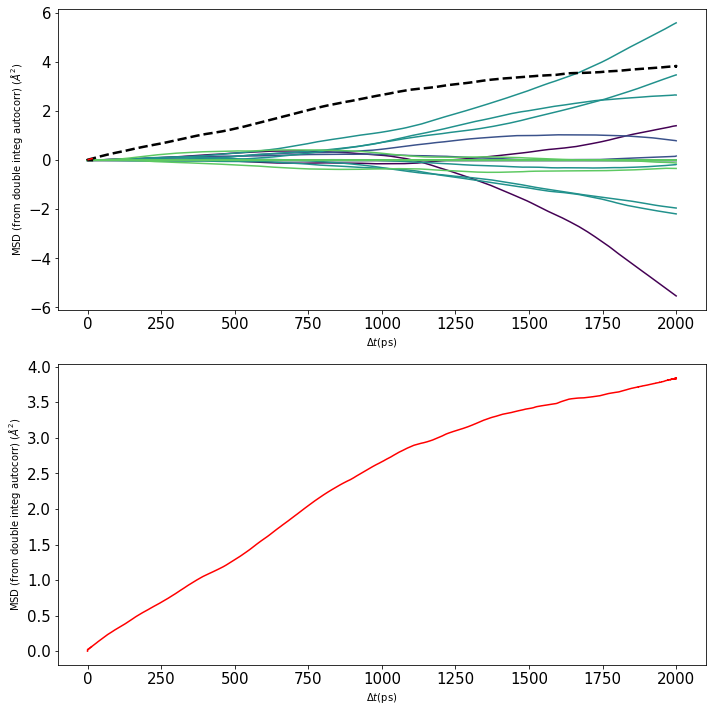

In [23]:
# Diffusion analysis after projection on different local environments

import numpy as np
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt

# Set a larger figure size
plt.figure(figsize=(10, 10))

# Create a 2x1 subplot
plt.subplot(2, 1, 1)
        
cross_corr_final_totalsum = np.zeros((vel_env_prjctd[0][0][0][0][0][:].shape[0]))
Dij = np.zeros((Nsites, Nsites, 2)) # For this specific case, each site is connected to the other site through two BNs!

# Set a colormap and normalize based on the loop index
colormap = plt.cm.get_cmap('viridis')  # You can choose any colormap
#colormap = plt.colormaps['viridis']
norm = plt.Normalize(0, Nsites)  # For color coding based on Nenv = Nsites

#begin_data = 100
#end_data = 10000

for envi in range(Nsites):
    print(envi)
    for envj in range(Nsites):
        for BNindx in range(2):
            cross_corr_final = np.zeros((vel_env_prjctd[0][0][0][0][0][:].shape[0]))
            for nLi in range(NLi):
                for alpha in range(3):
                    vel_under_consideration = vel_env_prjctd[envi][envj][BNindx][nLi][alpha][:]
                    #print(vel_under_consideration.shape)
                    vel_under_consideration2 = vel[nLi::NLi, alpha]

                    #print(vel_under_consideration.shape)
                    #print(vel_under_consideration2.shape)

                    var1 = vel_under_consideration
                    var2 = vel_under_consideration2

                    cross_corr_result = cross_correlation_fft_zero_padding_normalized(var1, var2)
                    cross_corr_final += cross_corr_result[0: len(vel_under_consideration)]

            cross_corr_final /= (NLi * 3 * 10) # 10 is for conversion from A^2/fs to cm^2/s
            cross_corr_final_totalsum += cross_corr_final

            # Generate x-axis values (time * 0.001)
            x_values = np.arange(len(cross_corr_final)) * 1.0 # Let's keep the values on the x-axis as fs

            # Calculate the cumulative integral using cumtrapz
            cumulative_integral_values_env_based = cumtrapz(cross_corr_final, x=x_values, initial=0)
            cumulative_integral_values_env_based_2 = cumtrapz(cumulative_integral_values_env_based, x=x_values, initial=0)
            #print(cumulative_integral_values.shape)

            # Assuming x_values, cross_corr_final, and cumulative_integral_values are defined

            # Calculate the cumulative integral using trapz
            #cumulative_integral = trapz(cross_corr_final, x=x_values)

            color = colormap(norm(envi))
            #plt.plot(x_values, cross_corr_final, color='b')
            #plt.plot(x_values, cumulative_integral_values_env_based, color=color)

            ### Moving average
            # Define the window length
            #window_length = 5000
            # Calculate the moving average
            #cumulative_integral_values_moving_average = np.convolve(cumulative_integral_values_env_based, np.ones(window_length)/window_length, mode='valid')
            #x_values_moving_average = np.arange(len(cumulative_integral_values_moving_average)) * 1.0

            plt.plot(x_values / 1000, cumulative_integral_values_env_based_2, color=color)

            x_for_plot = x_values
            y_for_plot = cumulative_integral_values_env_based_2

            # Perform linear fit
            y_for_fit = y_for_plot[begin_data:end_data]
            x_for_fit = x_for_plot[begin_data:end_data]
            p = np.polyfit(x_for_fit, y_for_fit, 1)

            # Plot the linear fit
            #plt.plot(x_for_fit / 1000, np.polyval(p, x_for_fit), 'k--', linewidth=1.5)
            plt.plot(x_for_fit / 1000, np.polyval(p, x_for_fit), 'k--')

            # Display the slope in cm^2/s
            D_in_cm2_per_s = p[0] * 0.5 # the 0.5 coeff is for doeble integral with double counting! (slide 13 in the pdf by Zabaras) # NO need for 0.1 is to convert from A^2/fs to cm^2/s (applied previously) 
            #print("D (cm^2/s):", D_in_cm2_per_s)

            #Dij[envi][envj] = np.mean(cumulative_integral_values_moving_average[begin_data:end_data]) # cm^2/s
            Dij[envi][envj][BNindx] = D_in_cm2_per_s # cm^2/s
            #print("D from int_autocorr (cm^2/s):", D_in_cm2_per_s_from_int_autocorr)

# Calculate the cumulative integral using cumtrapz
cumulative_integral_cross_corr_final_totalsum = cumtrapz(cross_corr_final_totalsum, x=x_values, initial=0)
cumulative_integral_cross_corr_final_totalsum_2 = cumtrapz(cumulative_integral_cross_corr_final_totalsum, x=x_values, initial=0)
plt.plot(x_values / 1000, cumulative_integral_cross_corr_final_totalsum_2, color='black', linestyle='dashed', linewidth=2.5)

x = x_values
y = cumulative_integral_cross_corr_final_totalsum_2

# Perform linear fit
y_for_fit = y[begin_data:end_data]
x_for_fit = x[begin_data:end_data]
p = np.polyfit(x_for_fit, y_for_fit, 1)

# Plot the linear fit
plt.plot(x_for_fit / 1000, np.polyval(p, x_for_fit), 'r--', linewidth=1.5)

# Display the slope in cm^2/s
D_in_cm2_per_s = p[0] * 0.5 # the 0.5 coeff is for doeble integral with double counting! (slide 13 in the pdf by Zabaras) # NO need for 0.1 is to convert from A^2/fs to cm^2/s (applied previously) 
print("D (cm^2/s):", D_in_cm2_per_s)

# Set plot properties
plt.xlabel('$\Delta t$(ps)')
plt.ylabel('MSD (from double integ autocorr) ($\\AA^2$)')
#plt.title('Mean Squared Displacement vs. Time')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(2, 1, 2)
# Plot the cumulative integral
plt.plot(x_values / 1000, cumulative_integral_values_2, color='r') # From past

x = x_values
y = cumulative_integral_values_2

# Perform linear fit
y_for_fit = y[begin_data:end_data]
x_for_fit = x[begin_data:end_data]
p = np.polyfit(x_for_fit, y_for_fit, 1)

# Plot the linear fit
plt.plot(x_for_fit / 1000, np.polyval(p, x_for_fit), 'r--', linewidth=1.5)

# Display the slope in cm^2/s
D_in_cm2_per_s = p[0] * 0.5 # the 0.5 coeff is for doeble integral with double counting! (slide 13 in the pdf by Zabaras) # NO need for 0.1 is to convert from A^2/fs to cm^2/s (applied previously) 
print("D (cm^2/s):", D_in_cm2_per_s)

# Set plot properties
plt.xlabel('$\Delta t$(ps)')
plt.ylabel('MSD (from double integ autocorr) ($\\AA^2$)')
#plt.title('Mean Squared Displacement vs. Time')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
#plt.show()
plt.savefig('Figure_MSD_after_projection.png')


In [24]:
def BN_calculator(Num_4O_BNs, indx_4O_BNs, coords_O, L):
    indx_4O_BNs = indx_4O_BNs.copy()
    #indx_4O_BNs -= 1
    area_effective = np.zeros(Num_4O_BNs)
    dist_ha_BN_center = np.zeros(Num_4O_BNs)
    for num_BN in range(Num_4O_BNs):
        area = np.zeros(4)
        if num_BN < 6:
            #Triangle 1 [0,1,2]
            Tri_indx_sub = [0, 1, 2]
            Tri_indx = [indx_4O_BNs[num_BN, Tri_indx_sub[0]],
                        indx_4O_BNs[num_BN, Tri_indx_sub[1]],
                        indx_4O_BNs[num_BN, Tri_indx_sub[2]]]
            #print(Tri_indx)
            dist_cart = np.zeros([3,3])
            dist_cart[0] = coords_O[Tri_indx[0]] - coords_O[Tri_indx[1]]
            dist_cart[1] = coords_O[Tri_indx[0]] - coords_O[Tri_indx[2]]
            dist_cart[2] = coords_O[Tri_indx[1]] - coords_O[Tri_indx[2]]
            #dist_cart_PBC_corrected = perform_PBC(L, dist_cart)
            dist_cart_PBC_corrected = dist_cart
            Natoms_trainagle_calc = 3
            d = np.zeros(Natoms_trainagle_calc)
            count = 0
            for i in np.arange(0,Natoms_trainagle_calc,1):
                d[count] = np.sqrt(np.sum(np.square(dist_cart_PBC_corrected[i])))
                count += 1
            p = np.sum(d)/2
            area[0] = np.sqrt(p*(p-d[0])*(p-d[1])*(p-d[2]))
            #print(area[0])
            #Triangle 2 [0,1,3]
            Tri_indx_sub = [0, 1, 3]
            Tri_indx = [indx_4O_BNs[num_BN, Tri_indx_sub[0]],
                        indx_4O_BNs[num_BN, Tri_indx_sub[1]],
                        indx_4O_BNs[num_BN, Tri_indx_sub[2]]]
            dist_cart = np.zeros([3,3])
            dist_cart[0] = coords_O[Tri_indx[0]] - coords_O[Tri_indx[1]]
            dist_cart[1] = coords_O[Tri_indx[0]] - coords_O[Tri_indx[2]]
            dist_cart[2] = coords_O[Tri_indx[1]] - coords_O[Tri_indx[2]]
            #dist_cart_PBC_corrected = perform_PBC(L, dist_cart)
            dist_cart_PBC_corrected = dist_cart
            Natoms_trainagle_calc = 3
            d = np.zeros(Natoms_trainagle_calc)
            count = 0
            for i in np.arange(0,Natoms_trainagle_calc,1):
                d[count] = np.sqrt(np.sum(np.square(dist_cart_PBC_corrected[i])))
                count += 1
            p = np.sum(d)/2
            area[1] = np.sqrt(p*(p-d[0])*(p-d[1])*(p-d[2]))

            #Triangle 3 [2,3,0]
            Tri_indx_sub = [2,3,0]
            Tri_indx = [indx_4O_BNs[num_BN, Tri_indx_sub[0]],
                        indx_4O_BNs[num_BN, Tri_indx_sub[1]],
                        indx_4O_BNs[num_BN, Tri_indx_sub[2]]]
            dist_cart = np.zeros([3,3])
            dist_cart[0] = coords_O[Tri_indx[0]] - coords_O[Tri_indx[1]]
            dist_cart[1] = coords_O[Tri_indx[0]] - coords_O[Tri_indx[2]]
            dist_cart[2] = coords_O[Tri_indx[1]] - coords_O[Tri_indx[2]]
            #dist_cart_PBC_corrected = perform_PBC(L, dist_cart)
            dist_cart_PBC_corrected = dist_cart        
            Natoms_trainagle_calc = 3
            d = np.zeros(Natoms_trainagle_calc)
            count = 0
            for i in np.arange(0,Natoms_trainagle_calc,1):
                d[count] = np.sqrt(np.sum(np.square(dist_cart_PBC_corrected[i])))
                count += 1
            p = np.sum(d)/2
            area[2] = np.sqrt(p*(p-d[0])*(p-d[1])*(p-d[2]))

            #Triangle 4 [2,3,1]
            Tri_indx_sub = [2,3,1]
            Tri_indx = [indx_4O_BNs[num_BN, Tri_indx_sub[0]],
                        indx_4O_BNs[num_BN, Tri_indx_sub[1]],
                        indx_4O_BNs[num_BN, Tri_indx_sub[2]]]
            dist_cart = np.zeros([3,3])
            dist_cart[0] = coords_O[Tri_indx[0]] - coords_O[Tri_indx[1]]
            dist_cart[1] = coords_O[Tri_indx[0]] - coords_O[Tri_indx[2]]
            dist_cart[2] = coords_O[Tri_indx[1]] - coords_O[Tri_indx[2]]
            #dist_cart_PBC_corrected = perform_PBC(L, dist_cart)
            dist_cart_PBC_corrected = dist_cart
            Natoms_trainagle_calc = 3
            d = np.zeros(Natoms_trainagle_calc)
            count = 0
            for i in np.arange(0,Natoms_trainagle_calc,1):
                d[count] = np.sqrt(np.sum(np.square(dist_cart_PBC_corrected[i])))
                count += 1
            p = np.sum(d)/2
            area[3] = np.sqrt(p*(p-d[0])*(p-d[1])*(p-d[2]))
        else:
            coords_O_modified_for_four_corners = np.zeros((4,3))
            coords_O_modified_for_four_corners[0, :] = coords_O[indx_4O_BNs[num_BN, 0], :]
            coords_O_modified_for_four_corners[1, :] = coords_O[indx_4O_BNs[num_BN, 1], :]
            coords_O_modified_for_four_corners[2, :] = coords_O[indx_4O_BNs[num_BN, 2], :]
            coords_O_modified_for_four_corners[3, :] = coords_O[indx_4O_BNs[num_BN, 3], :]
            #if num_BN == 6:
            #    print(coords_O_modified_for_four_corners)
            if num_BN >= 6 and num_BN < 10: # Lx
                Lidx = 0
                if coords_O_modified_for_four_corners[0, Lidx] > L[Lidx,Lidx]/2:
                    coords_O_modified_for_four_corners[0, Lidx] -= L[Lidx,Lidx]
                if coords_O_modified_for_four_corners[1, Lidx] > L[Lidx,Lidx]/2:
                    coords_O_modified_for_four_corners[1, Lidx] -= L[Lidx,Lidx]
                coords_O_modified_for_four_corners[3, Lidx] -= L[Lidx,Lidx]
            elif num_BN >= 10 and num_BN < 14: # Ly
                Lidx = 1
                if coords_O_modified_for_four_corners[0, Lidx] > L[Lidx,Lidx]/2:
                    coords_O_modified_for_four_corners[0, Lidx] -= L[Lidx,Lidx]
                if coords_O_modified_for_four_corners[1, Lidx] > L[Lidx,Lidx]/2:
                    coords_O_modified_for_four_corners[1, Lidx] -= L[Lidx,Lidx]
                coords_O_modified_for_four_corners[3, Lidx] -= L[Lidx,Lidx]
            elif num_BN >= 14 and num_BN < 18: # Lz
                Lidx = 2
                if coords_O_modified_for_four_corners[0, Lidx] > L[Lidx,Lidx]/2:
                    coords_O_modified_for_four_corners[0, Lidx] -= L[Lidx,Lidx]
                if coords_O_modified_for_four_corners[1, Lidx] > L[Lidx,Lidx]/2:
                    coords_O_modified_for_four_corners[1, Lidx] -= L[Lidx,Lidx]
                coords_O_modified_for_four_corners[3, Lidx] -= L[Lidx,Lidx]
            elif num_BN >= 18 and num_BN < 20: # LxLy
                for Lidx in [0, 1]:
                    for Oid in range(4):
                        if coords_O_modified_for_four_corners[Oid, Lidx] > L[Lidx,Lidx]/2:
                            coords_O_modified_for_four_corners[Oid, Lidx] -= L[Lidx,Lidx]
            elif num_BN >= 20 and num_BN < 22: # LxLz
                for Lidx in [0, 2]:
                    for Oid in range(4):
                        if coords_O_modified_for_four_corners[Oid, Lidx] > L[Lidx,Lidx]/2:
                            coords_O_modified_for_four_corners[Oid, Lidx] -= L[Lidx,Lidx]
            #elif num_BN >= 22 and num_BN < 24: # LxLy
            else: # LyLz
                for Lidx in [1, 2]:
                    for Oid in range(4):
                        if coords_O_modified_for_four_corners[Oid, Lidx] > L[Lidx,Lidx]/2:
                            coords_O_modified_for_four_corners[Oid, Lidx] -= L[Lidx,Lidx]
            #if num_BN == 6:
            #    print(coords_O_modified_for_four_corners)
            #Triangle 1 [0,1,2]
            Tri_indx_sub = [0, 1, 2]
            #Tri_indx = [indx_4O_BNs[num_BN, Tri_indx_sub[0]],
            #            indx_4O_BNs[num_BN, Tri_indx_sub[1]],
            #            indx_4O_BNs[num_BN, Tri_indx_sub[2]]]
            dist_cart = np.zeros([3,3])
            dist_cart[0] = coords_O_modified_for_four_corners[Tri_indx_sub[0]] - coords_O_modified_for_four_corners[Tri_indx_sub[1]]
            dist_cart[1] = coords_O_modified_for_four_corners[Tri_indx_sub[0]] - coords_O_modified_for_four_corners[Tri_indx_sub[2]]
            dist_cart[2] = coords_O_modified_for_four_corners[Tri_indx_sub[1]] - coords_O_modified_for_four_corners[Tri_indx_sub[2]]
            #dist_cart_PBC_corrected = perform_PBC(L, dist_cart)
            dist_cart_PBC_corrected = dist_cart
            Natoms_trainagle_calc = 3
            d = np.zeros(Natoms_trainagle_calc)
            count = 0
            for i in np.arange(0,Natoms_trainagle_calc,1):
                d[count] = np.sqrt(np.sum(np.square(dist_cart_PBC_corrected[i])))
                count += 1
            p = np.sum(d)/2
            area[0] = np.sqrt(p*(p-d[0])*(p-d[1])*(p-d[2]))

            #Triangle 2 [0,1,3]
            Tri_indx_sub = [0, 1, 3]
            #Tri_indx = [indx_4O_BNs[num_BN, Tri_indx_sub[0]],
            #            indx_4O_BNs[num_BN, Tri_indx_sub[1]],
            #            indx_4O_BNs[num_BN, Tri_indx_sub[2]]]
            dist_cart = np.zeros([3,3])
            dist_cart[0] = coords_O_modified_for_four_corners[Tri_indx_sub[0]] - coords_O_modified_for_four_corners[Tri_indx_sub[1]]
            dist_cart[1] = coords_O_modified_for_four_corners[Tri_indx_sub[0]] - coords_O_modified_for_four_corners[Tri_indx_sub[2]]
            dist_cart[2] = coords_O_modified_for_four_corners[Tri_indx_sub[1]] - coords_O_modified_for_four_corners[Tri_indx_sub[2]]
            #dist_cart_PBC_corrected = perform_PBC(L, dist_cart)
            dist_cart_PBC_corrected = dist_cart
            Natoms_trainagle_calc = 3
            d = np.zeros(Natoms_trainagle_calc)
            count = 0
            for i in np.arange(0,Natoms_trainagle_calc,1):
                d[count] = np.sqrt(np.sum(np.square(dist_cart_PBC_corrected[i])))
                count += 1
            p = np.sum(d)/2
            area[1] = np.sqrt(p*(p-d[0])*(p-d[1])*(p-d[2]))

            #Triangle 3 [2,3,0]
            Tri_indx_sub = [2,3,0]
            #Tri_indx = [indx_4O_BNs[num_BN, Tri_indx_sub[0]],
            #            indx_4O_BNs[num_BN, Tri_indx_sub[1]],
            #            indx_4O_BNs[num_BN, Tri_indx_sub[2]]]
            dist_cart = np.zeros([3,3])
            dist_cart[0] = coords_O_modified_for_four_corners[Tri_indx_sub[0]] - coords_O_modified_for_four_corners[Tri_indx_sub[1]]
            dist_cart[1] = coords_O_modified_for_four_corners[Tri_indx_sub[0]] - coords_O_modified_for_four_corners[Tri_indx_sub[2]]
            dist_cart[2] = coords_O_modified_for_four_corners[Tri_indx_sub[1]] - coords_O_modified_for_four_corners[Tri_indx_sub[2]]
            #dist_cart_PBC_corrected = perform_PBC(L, dist_cart)
            dist_cart_PBC_corrected = dist_cart        
            Natoms_trainagle_calc = 3
            d = np.zeros(Natoms_trainagle_calc)
            count = 0
            for i in np.arange(0,Natoms_trainagle_calc,1):
                d[count] = np.sqrt(np.sum(np.square(dist_cart_PBC_corrected[i])))
                count += 1
            p = np.sum(d)/2
            area[2] = np.sqrt(p*(p-d[0])*(p-d[1])*(p-d[2]))

            #Triangle 4 [2,3,1]
            Tri_indx_sub = [2,3,1]
            #Tri_indx = [indx_4O_BNs[num_BN, Tri_indx_sub[0]],
            #            indx_4O_BNs[num_BN, Tri_indx_sub[1]],
            #            indx_4O_BNs[num_BN, Tri_indx_sub[2]]]
            dist_cart = np.zeros([3,3])
            dist_cart[0] = coords_O_modified_for_four_corners[Tri_indx_sub[0]] - coords_O_modified_for_four_corners[Tri_indx_sub[1]]
            dist_cart[1] = coords_O_modified_for_four_corners[Tri_indx_sub[0]] - coords_O_modified_for_four_corners[Tri_indx_sub[2]]
            dist_cart[2] = coords_O_modified_for_four_corners[Tri_indx_sub[1]] - coords_O_modified_for_four_corners[Tri_indx_sub[2]]
            #dist_cart_PBC_corrected = perform_PBC(L, dist_cart)
            dist_cart_PBC_corrected = dist_cart
            Natoms_trainagle_calc = 3
            d = np.zeros(Natoms_trainagle_calc)
            count = 0
            for i in np.arange(0,Natoms_trainagle_calc,1):
                d[count] = np.sqrt(np.sum(np.square(dist_cart_PBC_corrected[i])))
                count += 1
            p = np.sum(d)/2
            area[3] = np.sqrt(p*(p-d[0])*(p-d[1])*(p-d[2]))

        area_effective[num_BN] = (area[0] + area[1] + area[2] + area[3]) / 2
        #print(area[0], area[1], area[2], area[3])
            
    return area_effective

In [25]:
######## Related to BN calculation

def split_into_chunks(m_range, num_processes):
    chunk_size, remainder = divmod(len(m_range), num_processes)
    m_range = list(m_range)  # Convert the range to a list
    chunks = [m_range[i * chunk_size + min(i, remainder):(i + 1) * chunk_size + min(i + 1, remainder)] for i in range(num_processes)]    
    return chunks

def BN_calculator_call(chunk, Num_4O_BNs, indx_4O_BNs, coords_O, L, NOx):
    chunk = list(chunk)
    Nsnapshots3 = len(chunk)
    temp_coords_O_chunk = coords_O[chunk[0]*NOx:(chunk[-1]+1)*NOx:, :]
    area_effective_all_temp = np.zeros((Nsnapshots3, Num_4O_BNs))
    for ns in range(Nsnapshots3):
        #if ns % 10000 == 0 and ns > 0:
        #    print(ns)
        temp_coords_O = temp_coords_O_chunk[ns*NOx:(ns+1)*NOx, :]
        area_effective_all_temp[ns, :] = BN_calculator(Num_4O_BNs, indx_4O_BNs, temp_coords_O, L)
    return area_effective_all_temp

area_effective_all = np.zeros((Nsnapshots, Num_4O_BNs_all))
m_range = range(Nsnapshots)
chunks = split_into_chunks(m_range, num_processes)

with multiprocessing.Pool(num_processes) as pool:
    results = pool.starmap(BN_calculator_call, [(chunk, Num_4O_BNs_all, indx_4O_BNs_all, coords_O, L, NOx) for chunk in chunks])

area_effective_all = np.concatenate(results, axis=0)

file_name = f"./MD_BN_vs_t.txt"
# Save the array as a text file
np.savetxt(file_name, area_effective_all, fmt="%.3f", delimiter=" ")

import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a 2D NumPy array named 'area_effective_all'
# Nsnapshots rows and Num_4O_BNs columns
Num_4O_BNs_all = area_effective_all.shape[1]  # Assuming you have this variable defined

# Get the number of columns (Num_4O_BNs)
num_bns = area_effective_all.shape[1]

mean_values = np.zeros(area_effective_all.shape[1])
std_err_values = np.zeros(area_effective_all.shape[1])

# Iterate over different columns (Bottleneck Areas)
counter = 0
for bn_index in range(num_bns):
    # Extract data for a specific column (Bottleneck Area)
    data_for_bn = area_effective_all[:, bn_index]

    # Calculate the mean and standard error for the column
    mean_value = np.mean(data_for_bn)
    std_err_value = np.std(data_for_bn) # / np.sqrt(data_for_bn.shape[0]) Let's not normalize the st. deviation

    mean_values[counter] = mean_value
    std_err_values[counter] = std_err_value

    counter += 1

print(mean_values.shape)
print(std_err_values.shape)

filename_out = f"./MD_BN.txt"

with open(filename_out, "w") as file:
    for mean, std_err in zip(mean_values, std_err_values):
        file.write(f"{mean} {std_err}\n")

(24,)
(24,)


In [26]:
# Let's save the needed numbers for each pathway and BN In a vsc file
import pandas as pd

headers = [
    "site_i",
    "site_j",
    "x_site_i",
    "x_site_j",
    "BN#",
    "4O_indx",
    "BN_area_ave",
    "BN_area_std",
    "D_ij",
    "D_ji",
    "D_ave"
]

# Create a Pandas DataFrame with empty data
df = pd.DataFrame(columns=headers)

for i in range(Nsites):
    for j in range(Nsites):
        if j > i:
            if (BNO4_ids_matrix[i, j] != 0).any():
                # First BN
                thisBN = BNO4_ids_matrix[i, j, 0]
                row_data = {
                    "site_i": i,
                    "site_j": j,
                    "x_site_i": x_sites_direct[i],
                    "x_site_j": x_sites_direct[j],
                    "BN#": thisBN,
                    "4O_indx": indx_4O_BNs_all[thisBN]+1,
                    "BN_area_ave": mean_values[thisBN],
                    "BN_area_std": std_err_values[thisBN],
                    "D_ij": Dij[i][j][0],
                    "D_ji": Dij[j][i][0],
                    "D_ave": abs(Dij[i][j][0] + Dij[j][i][0])
                }
                df = df.append(row_data, ignore_index=True)
                # Second BN
                thisBN = BNO4_ids_matrix[i, j, 1]
                row_data = {
                    "site_i": i,
                    "site_j": j,
                    "x_site_i": x_sites_direct[i],
                    "x_site_j": x_sites_direct[j],
                    "BN#": thisBN,
                    "4O_indx": indx_4O_BNs_all[thisBN]+1,
                    "BN_area_ave": mean_values[thisBN],
                    "BN_area_std": std_err_values[thisBN],
                    "D_ij": Dij[i][j][1],
                    "D_ji": Dij[j][i][1],
                    "D_ave": abs(Dij[i][j][1] + Dij[j][i][1])
                }
                df = df.append(row_data, ignore_index=True)

#df.to_csv('D_ij_BN_info.csv', index=False)
df.to_csv("D_ij_BN_info.csv", float_format="%.6e", index=False)

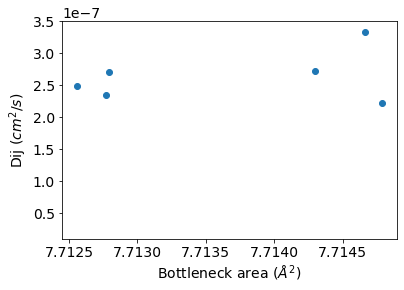

In [27]:
# Plot Dij vs BN

import matplotlib.pyplot as plt

# Initialize lists to store data points
BN_values = []
BN_std_values = []
D_values = []

for i in range(Nsites):
    for j in range(Nsites):
        if j > i:
            if (BNO4_ids_matrix[i, j] != 0).any():
                # First BN
                thisBN = BNO4_ids_matrix[i, j, 0]
                BN_values.append(mean_values[thisBN])
                BN_std_values.append(std_err_values[thisBN])
                D_values.append(abs(Dij[i][j][0] + Dij[j][i][0]))
                
                # Second BN
                thisBN = BNO4_ids_matrix[i, j, 1]
                BN_values.append(mean_values[thisBN])
                BN_std_values.append(std_err_values[thisBN])
                D_values.append(abs(Dij[i][j][1] + Dij[j][i][1]))

# Plot the scatter plot
plt.rcParams.update({'font.size': 14})
plt.scatter(BN_values, D_values)
plt.xlabel('Bottleneck area ($\\AA^2$)')
plt.ylabel('Dij ($cm^2/s$)')
#plt.xlim([7.5, 7.9])
plt.ylim([1e-8, 3.5e-7])
#plt.title('Scatter Plot')
plt.show()

# Combine arrays horizontally
data_np = np.column_stack((D_values, BN_values, BN_std_values))

# Save data to a file
np.savetxt('D_BN_std.txt', data_np, fmt=['%.6e', '%1.5f', '%1.5f'], delimiter='\t', header='D_values\tBN_values\tBN_std_values', comments='')


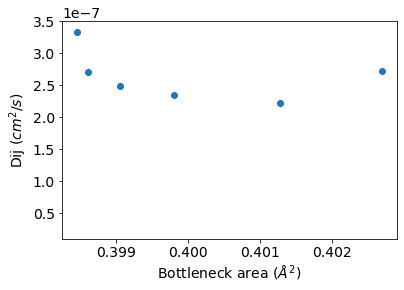

In [28]:
# Plot Dij vs BN

import matplotlib.pyplot as plt

# Initialize lists to store data points
BN_values = []
D_values = []

for i in range(Nsites):
    for j in range(Nsites):
        if j > i:
            if (BNO4_ids_matrix[i, j] != 0).any():
                # First BN
                thisBN = BNO4_ids_matrix[i, j, 0]
                BN_values.append(std_err_values[thisBN])
                D_values.append(abs(Dij[i][j][0] + Dij[j][i][0]))
                
                # Second BN
                thisBN = BNO4_ids_matrix[i, j, 1]
                BN_values.append(std_err_values[thisBN])
                D_values.append(abs(Dij[i][j][1] + Dij[j][i][1]))

# Plot the scatter plot
plt.rcParams.update({'font.size': 14})
plt.scatter(BN_values, D_values)
plt.xlabel('Bottleneck area ($\\AA^2$)')
plt.ylabel('Dij ($cm^2/s$)')
#plt.xlim([7.5, 7.9])
plt.ylim([1e-8, 3.5e-7])
#plt.title('Scatter Plot')
plt.show()


In [29]:
# Writing Dij to file
# Dij
filename = "./Dij" + ".txt"
f_Dij = open(filename, "w")
for i in range(Nsites):
    for j in range(Nsites):    
        f_Dij.write("%e " %(Dij[i, j]))
    f_Dij.write("\n")
f_Dij.close()

TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
def read_siteinfo_file_vals(filepath):
    filename = filepath
    with open(filename, "r") as f:
        lines = f.readlines()
    NatomstimesNtimes = len(lines)
    templ = lines[0].split()
    whatnow = len(templ)
    
    CN = np.zeros((NatomstimesNtimes, whatnow))

    # Read the cell vectors
    for i in range(NatomstimesNtimes):
        templ = lines[i].split()
        for j in range(whatnow):
            CN[i, j] = float(templ[j])

    return CN

In [ ]:
def read_siteinfo_file_indxs(filepath):
    filename = filepath
    with open(filename, "r") as f:
        lines = f.readlines()
    NatomstimesNtimes = len(lines)
    templ = lines[0].split()
    whatnow = len(templ)
    
    CN = np.zeros((NatomstimesNtimes, whatnow), dtype=int)

    # Read the cell vectors
    for i in range(NatomstimesNtimes):
        templ = lines[i].split()
        for j in range(whatnow):
            CN[i, j] = int(templ[j])

    return CN

In [ ]:
# I think you should define the number of sites here:
Natoms = NLi
#Nsites = 24

filepath = "./site_info_continuous_spectrum_topwhat_values" + ".txt"
CNLiLa_vals = read_siteinfo_file_vals(filepath)
print(CNLiLa_vals.shape)
whatnow = CNLiLa_vals.shape[1] # # Chosen number for simplification of the continuous site data spectrum
Ntimes = int(CNLiLa_vals.shape[0] / Nsites)

filepath = "./site_info_continuous_spectrum_topwhat_indices" + ".txt"
CNLiLa_indxs = read_siteinfo_file_indxs(filepath)
print(CNLiLa_indxs.shape)

In [ ]:
# Let's see if we can transform continuous format site_info to good old CNLiLa
# The only thing is that rows instead of atoms are here considered as sites
CNLiLa = np.zeros((Nsites, Ntimes))
for n in range(Ntimes):
    for i in range(Natoms):
        for j in range(whatnow):
            CNLiLa[CNLiLa_indxs[n*Natoms + i][j]][n] += CNLiLa_vals[n*Natoms + i][j]
            
row_sum_for_bar_chart = np.sum(CNLiLa, axis=1)

In [ ]:
# Bar chart of site distribution
x_axis = np.arange(row_sum_for_bar_chart.shape[0]) + 1
plt.rcParams.update({'font.size': 14})
plt.bar(x_axis, row_sum_for_bar_chart)
plt.xlabel("Site#")
plt.ylabel("Count")
plt.title('Site distribution')
#plt.show()
plt.savefig('Figure_Bar_chart_of_site_distribution.png')

In [ ]:
# Count the CN-LiLa content

#Natoms = CNLiLa.shape[0]
#Ntimes = CNLiLa.shape[1]

Nbins = Nsites

#count_CN_vector = np.zeros(Nbins)
#for na in range(Natoms):
#    for nt in range(Ntimes):
#        idy = int(CNLiLa[na, nt])
#        #if idy > 9:
#        #    idy = 9
#        count_CN_vector[idy] += 1
        
count_CN_vector = row_sum_for_bar_chart

In [ ]:
# Plot of summation of CN-LiLi & CN-LiLa | i.e., total A-site (cation) coordination of Li
# Shown as percent presence in the simulation

# Move to CN_count percentage
#Nbins = Nsites
mysum = 0
for i in range(Nbins):
    mysum += count_CN_vector[i]
        
count_CN_vector_normalized = count_CN_vector / mysum * 100 # percentage

count_CN_vector_normalized_sorted = -np.sort(-count_CN_vector_normalized)
count_CN_vector_normalized_sorted_ids = np.argsort(-count_CN_vector_normalized)
#print(count_CN_vector_normalized)

Nds = count_CN_vector_normalized.shape[0]
CN_ds = []
env_names = []
for i in range(Nds):
    letter1 = int(count_CN_vector_normalized_sorted_ids[i])
    nameit = "Site#%d" %(letter1+1)
    env_names.append(nameit)
    CN_ds.append(count_CN_vector_normalized_sorted[i])

# Barchart plot
xaxis = np.arange(Nds)

#fig = plt.figure()
#ax = plt.axes()
plt.figure(figsize=(200,60))
plt.rcParams.update({'font.size': 180})
plt.bar(xaxis, CN_ds, align='center') #, alpha=0.5)
plt.xticks(xaxis, env_names, rotation=90)
#plt.xticks(xaxis, env_names)
#plt.ylim(0, 60)
plt.ylabel('% Site-based local environment')
plt.title('Sorted % Site-based local environment')
#plt.show()
plt.savefig('Figure_Summation_of_CN.png')


In [ ]:
# Visualizing Dij matrix -- version 1 Heat map

x_axis_nums = np.arange(0, Nsites, 1)
y_axis_nums = np.arange(0, Nsites, 1)

#Heat map plotting from: https://gist.github.com/teechap/9c066a9ab054cc322877
x = x_axis_nums
y = y_axis_nums
intensity = Dij
x, y = np.meshgrid(x, y)

#plt.pcolormesh(np.transpose(x), np.transpose(y), intensity, vmin=0, vmax=.004, shading='auto')
plt.rcParams.update({'font.size': 13})
plt.pcolormesh(np.transpose(x), np.transpose(y), intensity, shading='auto')
plt.colorbar()
mytitle = 'Dij heat map'
plt.title(mytitle)
plt.xlabel('Site j')
plt.ylabel('Site i')
#plt.show()
plt.savefig('Figure_Dij_v1_Heat_map.png')


In [ ]:
# Visualizing Dij matrix -- version 2 Kinetic map without arrows and population declaration

Nds = Nsites
Nsize = Nds * Nds
x_Dij = np.zeros(Nsize)
y_Dij = np.zeros(Nsize)
z_Dij = np.zeros(Nsize)

env_names = []
for i in range(Nds):
    letter1 = int(count_CN_vector_normalized_sorted_ids[i])
    #letter2 = int(indxj_sorted[i])
    nameit = "Site#%d" %(letter1+1)
    env_names.append(nameit)
xtick_values = np.arange(Nds) + 1
ytick_values = np.arange(Nds) + 1

mycount = 0
for i in range(Nds):
    indxi_Dij = count_CN_vector_normalized_sorted_ids[i]# * 10 + indxj_sorted[i]
    for j in range(Nds):
        indxj_Dij = count_CN_vector_normalized_sorted_ids[j]# * 10 + indxj_sorted[j]
        x_Dij[mycount] = i + 1
        y_Dij[mycount] = j + 1
        z_Dij[mycount] = Dij[indxi_Dij, indxj_Dij]
        mycount += 1

cm = plt.cm.get_cmap('RdYlBu')
#cm = plt.colormaps.get_cmap('RdYlBu')
#sc = plt.scatter(x_Dij, y_Dij, c=z_Dij, vmin=0, vmax=20, s=35, cmap=cm)
plt.figure(figsize=(13, 10))
plt.rcParams.update({'font.size': 20})
sc = plt.scatter(x_Dij, y_Dij, c=z_Dij, s=1100, cmap=cm)
plt.colorbar(sc)
plt.xticks(xtick_values, env_names, rotation = 90)
plt.yticks(ytick_values, env_names)
plt.title("Kinetic map | Dij Heat Map", fontsize=35)
plt.xlabel("Sorted site-based local environment", fontsize=25)
plt.ylabel("Sorted site-based local environment", fontsize=25)
#plt.show()
plt.savefig('Figure_Dij_v2_Kinetic_map_without_arrows.png')


In [ ]:
Nbins = Dij.shape[0]
Dij_summed_over_rows = np.zeros(Nbins)
Dij_summed_over_cols = np.zeros(Nbins)
for i in range(Nbins):
    mysum_row = 0
    mysum_col = 0
    for j in range(Nbins):
        mysum_row += Dij[i, j]
        mysum_col += Dij[j, i]
    Dij_summed_over_rows[i] = mysum_row
    Dij_summed_over_cols[i] = mysum_col

Nds = Nsites
xaxis = np.arange(Nds) + 1
Dij_summed_over_rows_ds = np.zeros(Nds)
Dij_summed_over_cols_ds = np.zeros(Nds)
env_names = []
for i in range(Nds):
    letter1 = int(count_CN_vector_normalized_sorted_ids[i])
    nameit = "Site#%d" %(letter1+1)
    env_names.append(nameit)

for i in range(Nds):
    indxi_Dij = count_CN_vector_normalized_sorted_ids[i]# * 10 + indxj_sorted[i]
    Dij_summed_over_rows_ds[i] = Dij_summed_over_rows[indxi_Dij]
    Dij_summed_over_cols_ds[i] = Dij_summed_over_cols[indxi_Dij]
    
fig,ax = plt.subplots(1, 2, figsize=(20, 5))
#plt.figure(figsize=(200,60))
ax[0].bar(xaxis, Dij_summed_over_rows_ds, align='center') #, alpha=0.5)
ax[1].bar(xaxis, Dij_summed_over_cols_ds, align='center') #, alpha=0.5)
ax[0].set_xticks(xaxis)
ax[1].set_xticks(xaxis)
ax[0].set_xticklabels(env_names, rotation = 90)
ax[1].set_xticklabels(env_names, rotation = 90)
#ax[0].set_ylim(0, .8e-7)
#ax[1].set_ylim(0, .8e-7)
plt.rcParams.update({'font.size': 19})
ax[0].set_xlabel("Sorted env. based on percent presence", fontsize = 27, labelpad=20)
ax[1].set_xlabel("Sorted env. based on percent presence", fontsize = 27, labelpad=20)
ax[0].set_ylabel("Contrib. to diff. ($cm^2/s$)", fontsize = 27, labelpad=20)
ax[0].set_title('Summation over Dij rows', fontsize = 27)
ax[1].set_title('Summation over Dij columns', fontsize = 27)
#plt.show()
plt.savefig('Figure_CN_analysis_1_2.png')

fig = plt.figure()
plt.rcParams.update({'font.size': 20})
plt.scatter(Dij_summed_over_rows_ds, Dij_summed_over_cols_ds, s=40)
plt.title("Comparison Dij_summed_over rows vs. cols", fontsize=25, y=1.10)
plt.xlabel("Environment", fontsize=25, labelpad=20)
plt.ylabel("Environment", fontsize=25, labelpad=20)
#plt.xlim(0, 1e-7)
#plt.ylim(0, 1e-7)
plt.savefig('Figure_CN_analysis_3_summation.png')

In [ ]:
count_CN_vector_normalized = count_CN_vector / mysum * 100 # percentage

#count_CN_vector_normalized_sorted = -np.sort(-count_CN_vector_normalized)
#count_CN_vector_normalized_sorted_ids = np.argsort(-count_CN_vector_normalized)
#print(count_CN_vector_normalized)

Nds = Nsites # count_CN_vector_normalized.shape[0]
CN_ds = []
env_names = []
for i in range(Nds):
    #letter1 = int(count_CN_vector_normalized_sorted_ids[i])
    letter1 = int(i)
    nameit = "Site#%d" %(letter1+1)
    env_names.append(nameit)
    CN_ds.append(count_CN_vector_normalized[i])

In [ ]:
# Visualizing Dij matrix -- version 3 Kinetic map with arrows and population declaration

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle
from matplotlib.patches import ArrowStyle

# Example node labels
#node_labels = ['Node 1', 'Node 2', 'Node 3', 'Node 4', 'Node 5']
node_labels = env_names

# Input Parameters
fig_size = 15  # Size of the figure (both width and height)
self_loop_distance = 0.00  # Distance of self-loop circles from nodes
threshold = 9*10**-8  # Threshold for log10 values below which no arrow is drawn

# For scaling arrow size with respect to its thickness
thickness_scale_arrow_headlength = 6
thickness_scale_arrow_headwidth = 6

# For scaling line thickness for arrow and semi_self_loop
thickness_scale = 10

# Margin value for the plot
margin = 0.28
margin_scale_text = 0.15

# Radius of self_loop circles
radius_self_loop = .15

# Line Colors
blue_color = 'black' # 'blue'
red_color = 'red' # 'red'
self_loop_color = 'black'

# Line Styles
self_loop_line_style = '-|>'

# Create a custom arrow style
#arrow_style = ArrowStyle('simple', head_length=0.5, head_width=1, tail_width=0.2)

# Example asymmetric transition matrix with super small values
#transition_matrix = np.array([
#    [1e-10, 1e-9, 1e-10, 1e-9, 1e-8],
#    [1e-9, 1e-10, 1e-9, 1e-8, 1e-7],
#    [1e-8, 1e-7, 1e-10, 3e-6, 1e-10],
#    [1e-10, 1e-8, 1e-9, 1e-10, 1e-8],
#    [1e-9, 1e-10, 1e-8, 1e-7, 0.5e-5]
#])

transition_matrix = abs(Dij[0:Nds, 0:Nds]) + 10**-20
#print(transition_matrix)

# Example population array for the nodes
#population = np.array([100, 200, 150, 120, 80])
population = np.array(CN_ds) + 0.3

# Normalize the population values to a suitable range for node sizes
node_sizes = population / max(population) * 0.1

# Calculate the log10 values for arrow thickness
log10_transition_matrix = np.log10(transition_matrix)
#print(log10_transition_matrix)

# Create a circle grid
theta = np.linspace(0, 2 * np.pi, len(transition_matrix), endpoint=False)
radius = 1.0
x = radius * np.cos(theta)
y = radius * np.sin(theta)

# Calculate the center of the polygon
center_x = np.mean(x)
center_y = np.mean(y)

# Create a figure and axis with larger size
fig, ax = plt.subplots(figsize=(fig_size, fig_size))
ax.set_aspect('equal')

# Plot nodes with sizes proportional to population and add labels outside self-loops
for i in range(len(transition_matrix)):
    node = Circle((x[i], y[i]), radius=node_sizes[i], color='magenta')
    ax.add_patch(node)
    
    # Calculate the direction vector of the arrow
    dir_x = x[i] - center_x
    dir_y = y[i] - center_y
            
    # Normalize the direction vector
    dir_len = np.sqrt(dir_x ** 2 + dir_y ** 2)
    dir_x /= dir_len
    dir_y /= dir_len
    
    # Calculate the position of the label outside the self-loop circle
    label_x = x[i] + (radius_self_loop + margin_scale_text) * dir_x
    label_y = y[i] + (radius_self_loop + margin_scale_text) * dir_y
    
    # Add bold label outside the self-loop circle
    ax.text(label_x, label_y, node_labels[i], fontsize=14, fontweight='bold', verticalalignment='center')

# Add arrows and self-loops
for i in range(len(transition_matrix)):
    for j in range(len(transition_matrix)):
        if i > j and transition_matrix[i, j] > threshold:
            # Calculate the position of nodes at arrow ends
            start_x = x[i]
            start_y = y[i]
            end_x = x[j]
            end_y = y[j]
            
            # Calculate arrow thickness
            thickness = (log10_transition_matrix[i, j] + abs(np.log10(threshold))) * thickness_scale
            arrow_style = ArrowStyle('simple', head_length=thickness_scale_arrow_headlength*thickness, head_width=thickness_scale_arrow_headwidth*thickness, tail_width=thickness)
            # Blue arrow from i to j
            usethisrad = 1./(i-j)*0.1
            connectionstyle_text = "arc3,rad=%f" %(usethisrad)
            if Dij[i, j] >= 0:
                blue_color = 'black'
            else:
                blue_color = 'red'
            blue_arrow = FancyArrowPatch((start_x, start_y), (end_x, end_y),
                                         arrowstyle=arrow_style,
                                         #mutation_scale=15 * thickness,  # Adjusted arrow size
                                         color=blue_color,
                                         linewidth=0.0,  # Set linewidth to 0
                                         connectionstyle=connectionstyle_text)  # Same curvature
            ax.add_patch(blue_arrow)

        elif i == j and transition_matrix[i, j] > threshold:
            # Calculate the position of the self-loop circle
            loop_x = x[j] + self_loop_distance * dir_x
            loop_y = y[j] + self_loop_distance * dir_y
            
            # Calculate self-loop circle thickness based on diagonal log10 value
            thickness = (log10_transition_matrix[i, j] + abs(np.log10(threshold))) * thickness_scale
            
            # Add the self-loop circle in black with adjusted thickness
            loop = Circle((loop_x, loop_y), radius=radius_self_loop,
                          edgecolor=self_loop_color, facecolor='none',
                          linewidth=thickness)  # Set linewidth to 0
            ax.add_patch(loop)

        elif i < j and transition_matrix[i, j] > threshold:
            # Calculate the position of nodes at arrow ends
            start_x = x[j]
            start_y = y[j]
            end_x = x[i]
            end_y = y[i]
            
            # Calculate arrow thickness
            thickness = (log10_transition_matrix[i, j] + abs(np.log10(threshold))) * thickness_scale
            arrow_style = ArrowStyle('simple', head_length=thickness_scale_arrow_headlength*thickness, head_width=thickness_scale_arrow_headwidth*thickness, tail_width=thickness)
            # Red arrow from j to i
            usethisrad = 1./(j-i)*0.1
            connectionstyle_text = "arc3,rad=%f" %(usethisrad)
            if Dij[i, j] >= 0:
                red_color = 'black'
            else:
                red_color = 'red'
            red_arrow = FancyArrowPatch((end_x, end_y), (start_x, start_y),
                                        arrowstyle=arrow_style,
                                        #mutation_scale=15 * thickness,  # Adjusted arrow size
                                        color=red_color,
                                        linewidth=0.0,  # Set linewidth to 0
                                        connectionstyle=connectionstyle_text)  # Same curvature
            ax.add_patch(red_arrow)

# List of Diffusivity corresponding to the different thickness values
Diffusivity_vals = [1e-7, 5e-7]

# Create a custom legend
legend_handles = []
for Dval in Diffusivity_vals:
    thickness = (np.log10(Dval) + abs(np.log10(threshold))) * thickness_scale
    #thickness = (log10_transition_matrix[i, j] + abs(np.log10(threshold))) * thickness_scale
    label = f'{Dval:.0e}'
    legend_handles.append(ax.plot([], [], color='black', linewidth=thickness, label=label)[0])

# Add a legend with the custom handles
legend_title = r'Diffusivity ($\mathrm{cm}^2/\mathrm{s}$)'  # Use LaTeX formatting for the unit
legend = ax.legend(handles=legend_handles, title=legend_title, loc='upper right', borderaxespad=0., fontsize=14)
legend.get_frame().set_linewidth(0)  # Remove border around legend

# Set legend title font size
legend.get_title().set_fontsize('14')

# Set plot limits, remove ticks, and show the plot
ax.set_xlim(-1.2 - margin, 1.2 + margin)
ax.set_ylim(-1.2 - margin, 1.2 + margin)
ax.set_xticks([])
ax.set_yticks([])

# Remove the box (spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#plt.title("Curved Arrows with Tangent Circular Loops for Asymmetric Transition Matrix")
#plt.show()
plt.savefig('Figure_Dij_v3_Kinetic_map_with_arrows.png')

In [ ]:
print(Dij)